In [ ]:
pip install chardet

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import chardet
import logging
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
# Helper functions
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()
    return chardet.detect(raw_data)['encoding']

def load_csv_with_encoding(file_path):
    encoding = detect_encoding(file_path)
    try:
        return pd.read_csv(file_path, encoding=encoding)
    except UnicodeDecodeError:
        for enc in ['utf-8', 'iso-8859-1', 'cp1252']:
            try:
                return pd.read_csv(file_path, encoding=enc)
            except UnicodeDecodeError:
                continue
    raise ValueError(f"Unable to read the file {file_path} with any common encoding")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

class DataPreprocessor:
    def __init__(self):
        self.le = LabelEncoder()
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='mean')

    def preprocess_spotify_data(self, df: pd.DataFrame) -> pd.DataFrame:
        features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                    'time_signature', 'popularity']

        # Convert features to numeric, replacing non-numeric values with NaN
        for feature in features:
            df[feature] = pd.to_numeric(df[feature], errors='coerce')

        # Remove rows with NaN values in the 'popularity' column
        df = df.dropna(subset=['popularity'])

        # Impute missing values for other features
        df[features] = self.imputer.fit_transform(df[features])

        # Scale numeric features
        df[features] = self.scaler.fit_transform(df[features])

        bool_columns = df.select_dtypes(include=['bool']).columns
        for col in bool_columns:
            df[col] = df[col].astype(int)

        df['track_name'] = df['track_name'].astype(str)
        df['artists'] = df['artists'].astype(str)

        categorical_columns = df.select_dtypes(include=['object', 'category']).columns
        for col in categorical_columns:
            if col not in ['track_name', 'artists']:
                df[col] = self.le.fit_transform(df[col].astype(str))

        return df[features + ['track_genre', 'track_name', 'artists']]

    def preprocess_user_data(self, spotify_df: pd.DataFrame, billboard_df: pd.DataFrame,
                             tweets_df: pd.DataFrame, concerts_df: pd.DataFrame) -> pd.DataFrame:
        spotify_df['track_name'] = spotify_df['track_name'].astype(str)
        spotify_df['artists'] = spotify_df['artists'].astype(str)
        billboard_df['song'] = billboard_df['song'].astype(str)
        billboard_df['artist'] = billboard_df['artist'].astype(str)
        tweets_df['Username'] = tweets_df['Username'].astype(str)
        concerts_df['Artist'] = concerts_df['Artist'].astype(str)

        merged_df = pd.merge(spotify_df, billboard_df, left_on=['track_name', 'artists'],
                             right_on=['song', 'artist'], how='outer')
        merged_df = pd.merge(merged_df, tweets_df, left_on='artists', right_on='Username', how='outer')
        merged_df = pd.merge(merged_df, concerts_df, left_on='artists', right_on='Artist', how='outer')

        numerical_columns = merged_df.select_dtypes(include=[np.number]).columns
        categorical_columns = merged_df.select_dtypes(include=['object', 'category']).columns

        # Convert numerical columns to numeric, replacing non-numeric values with NaN
        for col in numerical_columns:
            merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

        # Remove columns with all NaN values
        numerical_columns = numerical_columns[~merged_df[numerical_columns].isna().all()]

        # Impute missing values for numerical features
        merged_df[numerical_columns] = self.imputer.fit_transform(merged_df[numerical_columns])

        merged_df = merged_df.dropna(subset=['popularity'])
        merged_df[categorical_columns] = merged_df[categorical_columns].fillna('Unknown')

        bool_columns = merged_df.select_dtypes(include=['bool']).columns
        for col in bool_columns:
            merged_df[col] = merged_df[col].astype(int)

        for col in categorical_columns:
            if col not in ['track_name', 'artists', 'song', 'artist', 'Username', 'Artist']:
                merged_df[col] = self.le.fit_transform(merged_df[col].astype(str))

        merged_df[numerical_columns] = self.scaler.fit_transform(merged_df[numerical_columns])

        return merged_df

    # You can add any additional helper methods here if needed

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

class AudioComplexityPredictor:
    def __init__(self):
        self.rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        self.gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        self.ensemble_model = None

    def train(self, X: pd.DataFrame, y: pd.Series):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        self.rf_model.fit(X_train, y_train)
        self.gb_model.fit(X_train, y_train)

        self.ensemble_model = LinearRegression()
        ensemble_preds_train = np.column_stack((
            self.rf_model.predict(X_train),
            self.gb_model.predict(X_train)
        ))
        self.ensemble_model.fit(ensemble_preds_train, y_train)

        ensemble_preds_test = np.column_stack((
            self.rf_model.predict(X_test),
            self.gb_model.predict(X_test)
        ))
        ensemble_predictions = self.ensemble_model.predict(ensemble_preds_test)

        mse = mean_squared_error(y_test, ensemble_predictions)
        r2 = r2_score(y_test, ensemble_predictions)

        print(f"Ensemble Model - MSE: {mse}, R2: {r2}")

        # Feature importance
        feature_importance = self.rf_model.feature_importances_
        feature_names = X.columns
        importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
        importance_df = importance_df.sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=importance_df.head(10))
        plt.title('Top 10 Feature Importances')
        plt.tight_layout()
        plt.show()

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        rf_preds = self.rf_model.predict(X)
        gb_preds = self.gb_model.predict(X)
        ensemble_preds = np.column_stack((rf_preds, gb_preds))
        return self.ensemble_model.predict(ensemble_preds)

In [ ]:
class AudioFeaturePredictor:
    def __init__(self):
        self.complexity_model = None
        self.preprocessor = None

    def train(self, X: pd.DataFrame, y_complexity: pd.Series):
        numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
        categorical_features = X.select_dtypes(include=['object', 'category']).columns

        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        X_train, X_test, y_complexity_train, y_complexity_test = train_test_split(
            X, y_complexity, test_size=0.2, random_state=42
        )

        self.complexity_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

        X_train_preprocessed = self.preprocessor.fit_transform(X_train)
        X_test_preprocessed = self.preprocessor.transform(X_test)

        self.complexity_model.fit(X_train_preprocessed, y_complexity_train)

        complexity_predictions = self.complexity_model.predict(X_test_preprocessed)

        complexity_mse = mean_squared_error(y_complexity_test, complexity_predictions)
        complexity_r2 = r2_score(y_complexity_test, complexity_predictions)

        print(f"Complexity Model - MSE: {complexity_mse}, R2: {complexity_r2}")

        # Learning curve
        self.plot_learning_curve(self.complexity_model, X_train_preprocessed, y_complexity_train, "Complexity Model Learning Curve")

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        X_preprocessed = self.preprocessor.transform(X)
        return self.complexity_model.predict(X_preprocessed)

    def plot_learning_curve(self, estimator, X, y, title):
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.title(title)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

        plt.legend(loc="best")
        plt.tight_layout()
        plt.show()

In [ ]:
class UserBehaviorClustering:
    def __init__(self, n_clusters: int = 5):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.pca = PCA(n_components=2)

    def fit(self, X: pd.DataFrame):
        # Select only numeric columns
        numeric_columns = X.select_dtypes(include=[np.number]).columns
        X_numeric = X[numeric_columns]

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(X_numeric)

        # Apply PCA
        X_pca = self.pca.fit_transform(X_imputed)
        self.kmeans.fit(X_pca)

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=self.kmeans.labels_, cmap='viridis')
        plt.title('User Behavior Clusters')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.colorbar(scatter)
        plt.show()

        logging.info(f"User Behavior Clustering completed. Visualization displayed in the notebook.")

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        numeric_columns = X.select_dtypes(include=[np.number]).columns
        X_numeric = X[numeric_columns]
        X_imputed = SimpleImputer(strategy='mean').fit_transform(X_numeric)
        X_pca = self.pca.transform(X_imputed)
        return self.kmeans.predict(X_pca)

In [ ]:
# Playlist Generator (continued)
class PlaylistGenerator:
    def __init__(self, n_recommendations: int = 10):
        self.n_recommendations = n_recommendations
        self.tfidf = TfidfVectorizer(stop_words='english')

    def fit(self, df: pd.DataFrame):
        text_features = df['track_name'] + ' ' + df['track_genre']
        self.tfidf_matrix = self.tfidf.fit_transform(text_features)

        audio_features = ['danceability', 'energy', 'valence']
        self.audio_features = df[audio_features].values
        self.scaler = StandardScaler()
        self.audio_features_scaled = self.scaler.fit_transform(self.audio_features)

        self.track_ids = df['track_id'].values

    def generate_playlist(self, seed_track_id: str, mood: str) -> List[str]:
        seed_index = np.where(self.track_ids == seed_track_id)[0][0]

        text_sim = self.tfidf_matrix[seed_index] @ self.tfidf_matrix.T
        text_sim = text_sim.toarray().flatten()

        audio_sim = np.linalg.norm(self.audio_features_scaled - self.audio_features_scaled[seed_index], axis=1)
        audio_sim = 1 / (1 + audio_sim)  # Convert distance to similarity

        combined_sim = 0.7 * text_sim + 0.3 * audio_sim

        mood_mask = self.get_mood_mask(mood)
        combined_sim = combined_sim * mood_mask

        top_indices = np.argsort(combined_sim)[::-1][1:self.n_recommendations+1]
        return self.track_ids[top_indices].tolist()

    def get_mood_mask(self, mood: str) -> np.ndarray:
        if mood == 'happy':
            return (self.audio_features[:, 2] > 0.6).astype(int)  # High valence
        elif mood == 'energetic':
            return (self.audio_features[:, 1] > 0.7).astype(int)  # High energy
        elif mood == 'calm':
            return ((self.audio_features[:, 1] < 0.4) & (self.audio_features[:, 0] < 0.5)).astype(int)  # Low energy and danceability
        else:
            return np.ones(len(self.track_ids))  # No mood filter

Loading datasets...
Preprocessing data...
Shape of spotify_processed: (114000, 16)
Columns in spotify_processed: Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'popularity', 'track_genre', 'track_name', 'artists'],
      dtype='object')
Data types in spotify_processed:
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature      float64
popularity          float64
track_genre           int64
track_name           object
artists              object
dtype: object
Sample of spotify_processed:
   danceability    energy       key  loudness      mode  speechiness  \
0      0.629244 -0.717148 -1.210442  0.

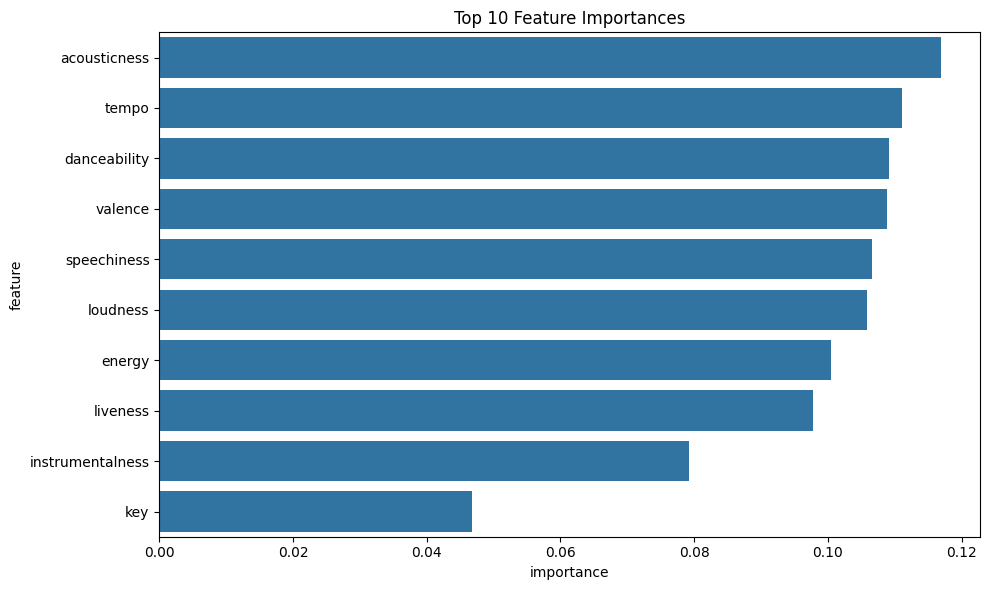

Training AudioFeaturePredictor...
Complexity Model - MSE: 0.47908025147736993, R2: 0.5170061110828991


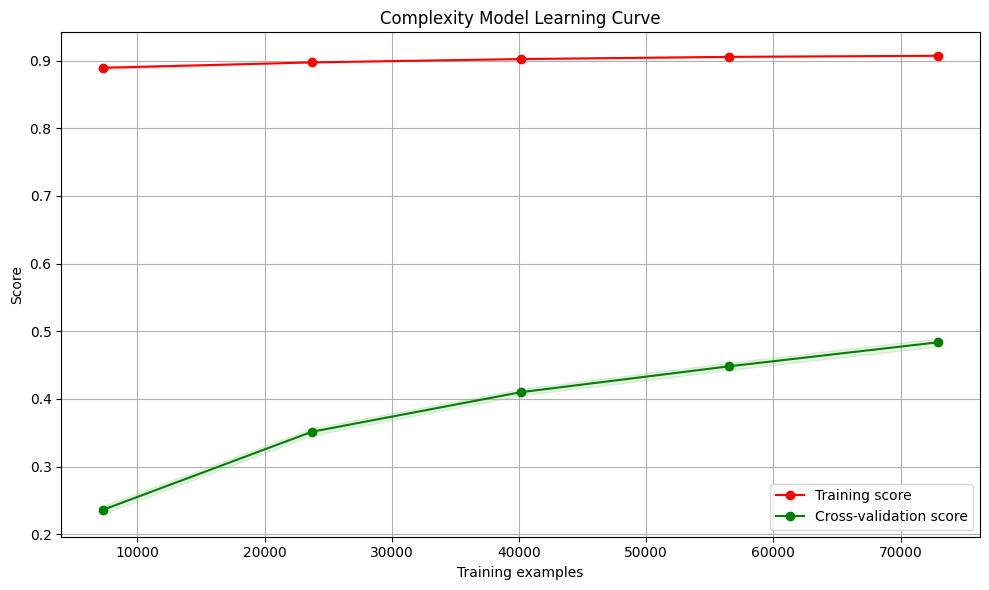

Predicting audio complexity...
Performing User Behavior Clustering...


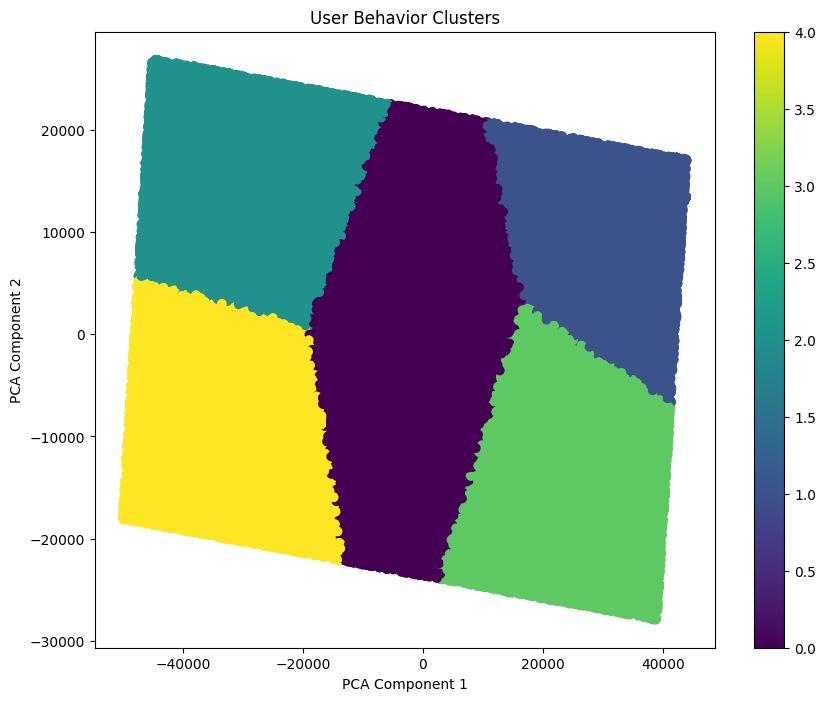

Training Playlist Generator...
Generating sample playlist...
Sample playlist for track 5SuOikwiRyPMVoIQDJUgSV:
               track_name                             artists
0                  Comedy                         Gen Hoshino
7               I'm Yours                          Jason Mraz
20              I'm Yours                          Jason Mraz
162             I'm Yours                          Jason Mraz
388                    ??                         Hanare Gumi
390               ???????                         Hanare Gumi
590     Can't Go Back Now  The Weepies;Deb Talan;Steve Tannen
591         ?????????????                         Hanare Gumi
805                  ????                         Shikao Suga
62102              Comedy                         Gen Hoshino
63658                  ??                         Hanare Gumi
63661             ???????                         Hanare Gumi
91904           I'm Yours                          Jason Mraz
99152              Co

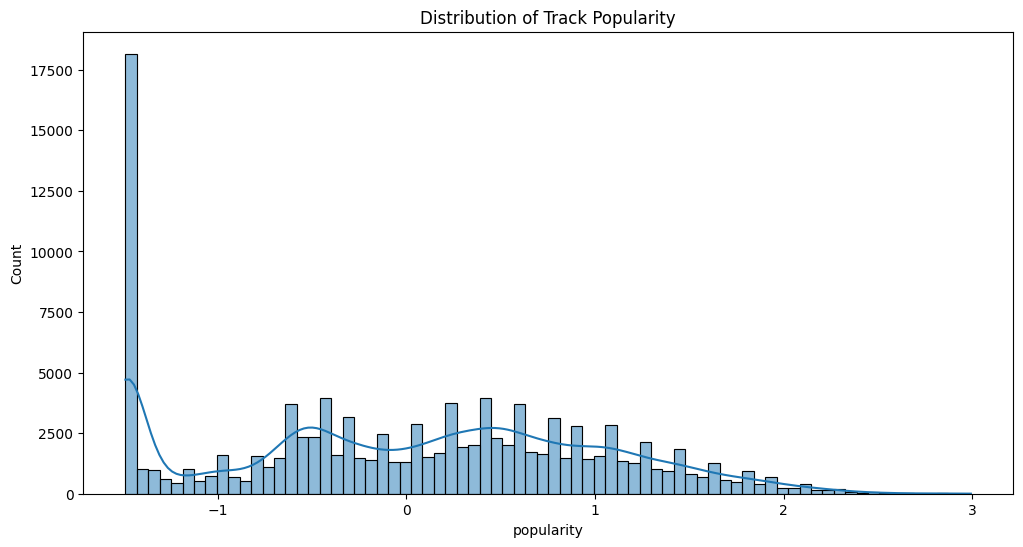

Generating correlation heatmap...


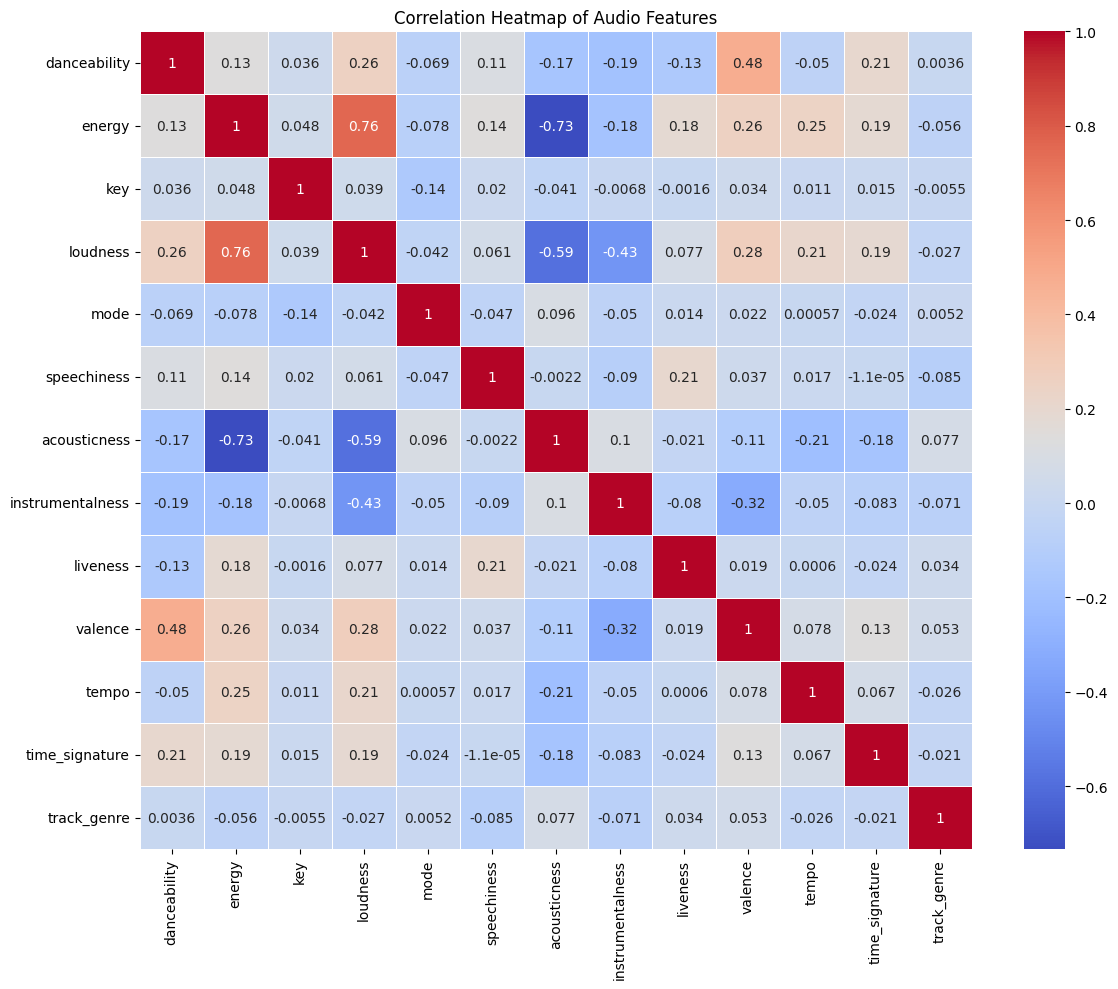

Process completed. Check the generated visualizations above.


In [ ]:
def main():
    try:
        # Load datasets
        print("Loading datasets...")
        spotify_df = load_csv_with_encoding('dataset.csv')
        billboard_df = load_csv_with_encoding('billboard_hot_100_2023.csv')
        tweets_df = load_csv_with_encoding('twitter_dataset.csv')
        concerts_df = load_csv_with_encoding('global_concert_data_2023.csv')

        # Preprocess data
        print("Preprocessing data...")
        preprocessor = DataPreprocessor()
        spotify_processed = preprocessor.preprocess_spotify_data(spotify_df)
        user_data = preprocessor.preprocess_user_data(spotify_df, billboard_df, tweets_df, concerts_df)

        # Print some debugging information
        print(f"Shape of spotify_processed: {spotify_processed.shape}")
        print(f"Columns in spotify_processed: {spotify_processed.columns}")
        print(f"Data types in spotify_processed:\n{spotify_processed.dtypes}")
        print(f"Sample of spotify_processed:\n{spotify_processed.head()}")

        # Train Audio Complexity Predictor
        print("Training Audio Complexity Predictor...")
        complexity_predictor = AudioComplexityPredictor()
        X_complexity = spotify_processed.drop(['popularity', 'track_genre', 'track_name', 'artists'], axis=1)
        y_complexity = spotify_processed['popularity']
        complexity_predictor.train(X_complexity, y_complexity)

        # Prepare features and target variables for AudioFeaturePredictor
        features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                    'time_signature', 'track_genre']
        X = spotify_processed[features]
        y_complexity = spotify_processed['popularity']

        # Train AudioFeaturePredictor
        print("Training AudioFeaturePredictor...")
        predictor = AudioFeaturePredictor()
        predictor.train(X, y_complexity)

        # Predict audio complexity
        print("Predicting audio complexity...")
        complexity_pred = predictor.predict(X)

        # Perform User Behavior Clustering
        print("Performing User Behavior Clustering...")
        clustering = UserBehaviorClustering()
        clustering.fit(user_data)

        # Train Playlist Generator
        print("Training Playlist Generator...")
        playlist_generator = PlaylistGenerator()
        playlist_generator.fit(spotify_df)

        # Generate sample playlist
        print("Generating sample playlist...")
        sample_track_id = spotify_df['track_id'].iloc[0]
        sample_playlist = playlist_generator.generate_playlist(sample_track_id, 'happy')
        print(f"Sample playlist for track {sample_track_id}:")
        print(spotify_df[spotify_df['track_id'].isin(sample_playlist)][['track_name', 'artists']])

        # Visualize data distribution
        print("Visualizing data distribution...")
        plt.figure(figsize=(12, 6))
        sns.histplot(data=spotify_processed, x='popularity', kde=True)
        plt.title('Distribution of Track Popularity')
        plt.show()

        # Correlation heatmap
        print("Generating correlation heatmap...")
        corr_matrix = spotify_processed[features].corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title('Correlation Heatmap of Audio Features')
        plt.tight_layout()
        plt.show()

        print("Process completed. Check the generated visualizations above.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()